Создадим датафреймы

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from datetime import timedelta
import seaborn as sns
import datetime as dt

Создадим датафреймы

In [2]:
df_c = pd.read_csv('olist_customers_dataset.csv', sep=',', dtype={'customer_unique_id': str})

In [3]:
df_o = pd.read_csv('olist_orders_dataset.csv', sep=',', dtype={'order_id': str}, parse_dates=['order_purchase_timestamp'], infer_datetime_format=True)

In [4]:
df_oi = pd.read_csv('olist_order_items_dataset.csv', sep=',')

In [5]:
#Проверим пропущенные значения
pd.isnull(df_c).sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [6]:
pd.isnull(df_o).sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [7]:
pd.isnull(df_oi).sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [8]:
#Объединяем датафреймы
df = df_o.merge(df_c, on = 'customer_id', how = 'left')
df = df.merge(df_oi,  on = 'order_id',    how = 'left')
df.shape

(113425, 18)

In [9]:
#Переименовываем необходимые столбцы для удобства
df = df.rename(columns={"order_purchase_timestamp": "order_date"})

Задание №1

Будем считать, что пользователь совершил покупку если стоит дата подтверждения заказа -  order_approved_at                 

In [10]:
df_client = df

In [11]:
df_client = df_client.rename(columns={"customer_unique_id": "client_id"})

Проведем группировку по клиентам, чтобы узнать количество заказов у каждого уникального пользователя
Проведем агрегацию, чтобы узнать количество заказов на каждый customer_unique_id (client_id)
Проведем фильтрацию по order_approved_at с значением равным 1, что и будет означать только 1 заказ.

In [12]:
#df_client.groupby('client_id').order_approved_at.count().reset_index().query('order_approved_at == "1"')

In [13]:
df_client = df_client.groupby(['client_id','order_approved_at'], as_index=False) \
    .agg({'order_approved_at': 'count'}) \
    .dropna() \
    .query('order_approved_at == "1"') \
    .sum()
df_client

client_id            0.0
order_approved_at    0.0
dtype: float64

89339 пользователей совершили покупку только 1 раз

Задание №2

Самое не однозначное задание :) Можно в качестве не доставленных заказов считать заказы с пропущеными значениями в order_delivered_customer_date и к ним прибавить заказы с статусом unavailable и canceled. Но мне кажется, что это ошибка в логах, поэтому там пропуски.
Поэтому пойдем другим путем, просто отберем заказы с статусом unavailable и canceled. Хотя в некоторых из них так же стоит дата доставки к клиенту (order_delivered_customer_date), что выглядит странно :/

In [14]:
#df_na = df[df.order_delivered_customer_date.isnull()]

In [15]:
#Пересохраняю исходный датафрейм
df_no_deliv = df

In [16]:
#Отбираю строки с нужным статусом заказа
df_no_deliv = df_no_deliv.query('order_status == ["unavailable","canceled"]') 

In [17]:
#Создаем отдельно столбец с месяцем заказа
def get_month(x): return dt.datetime(x.year, x.month, 1) 
df_no_deliv['month'] = df_no_deliv['order_date'].apply(get_month) 

C:\Users\kater\AppData\Local\Temp\ipykernel_18360\2182841532.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_deliv['month'] = df_no_deliv['order_date'].apply(get_month)


In [18]:
df_no_deliv = df_no_deliv[['order_id', 'month', 'order_status']]

In [19]:
df_no_deliv = df_no_deliv.groupby(['month', 'order_status'], as_index=False)\
    .agg({'order_id': 'count'})

In [20]:
df_no_deliv['month'] = df_no_deliv.month\
    .apply(lambda c: str(c).split()[0].split('-')[1] + '.' + str(c).split()[0].split('-')[0])
df_no_deliv.head()

,month,order_status,order_id
0,09.2016,canceled,2
1,10.2016,canceled,26
2,10.2016,unavailable,8
3,01.2017,canceled,3
4,01.2017,unavailable,10


In [21]:
df_no_deliv = df_no_deliv.groupby('order_status', as_index=False).mean('orders_id')
df_no_deliv

,order_status,order_id
0,canceled,29.416667
1,unavailable,29.047619


В среднем в месяц не доставлялось 29 (29.2) заказов. Из них 29.4 отменялись и 29 не доставлялись по причине недоступности товара

Задание №3

In [22]:
#Переприсваиваю общий дф для задания
df_product = df

In [23]:
#Отбираю нужные колонки
df_product = df_product[['order_id', 'product_id', 'order_date']].drop_duplicates()

In [24]:
#Создаю колонку с днем недели через дату создания заказа
df_product['day_of_week'] = df_product['order_date'].dt.day_name()

In [25]:
df_product.head(5)

,order_id,product_id,order_date,day_of_week
0,e481f51cbdc54678b7cc49136f2d6af7,87285b34884572647811a353c7ac498a,2017-10-02 10:56:33,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,595fac2a385ac33a80bd5114aec74eb8,2018-07-24 20:41:37,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,aa4383b373c6aca5d8797843e5594415,2018-08-08 08:38:49,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,d0b61bfb1de832b15ba9d266ca96e5b0,2017-11-18 19:28:06,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,65266b2da20d04dbe00c5c2d3bb7859e,2018-02-13 21:18:39,Tuesday


Далее провожу две группировки с агрегацией, сначала чтобы упорядочить в формате: заказ - количество - определенный день. Затем чтобы найти 'продуктивный' день недели

In [26]:
df_product = df_product.groupby(['product_id','day_of_week'], as_index=False) \
    .agg({'order_date': 'count'})

In [27]:
df_product = df_product.groupby('product_id', as_index=False) \
    .agg({'day_of_week': 'max'})

In [28]:
df_product

,product_id,day_of_week
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,Wednesday
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday
...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,Sunday
32947,fff81cc3158d2725c0655ab9ba0f712c,Monday
32948,fff9553ac224cec9d15d49f5a263411f,Friday
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday


Получаем таблицу в формате продукт - самый популярный для покупки этого продукта день. Это и есть конечный ответ

Задание №4

Пересохраним датафрейм.
Создадим 2 колонки с месяцем заказа и количеством недель в месяце

In [29]:
df_buy_week = df

In [30]:
df_buy_week['weeks'] = df_buy_week.order_date.dt.days_in_month/7 

In [31]:
def get_month(x): return dt.datetime(x.year, x.month, 1) 
df_buy_week['month'] = df_buy_week['order_date'].apply(get_month) 

В отдельную переменную сгруппируем данные по пользователям и месяцу. Агрегируем по уникальным заказам.

Создадим колонку количества заказов в неделю разделив заказы на число недель в месяце. Это ответ на вопрос

In [32]:
weekly_purchases = df_buy_week.groupby(['customer_unique_id', 'month'], as_index=False) \
                                .agg({'order_id' : 'nunique'})

In [33]:
df_buy_week['weekly_purchases'] = weekly_purchases['order_id']/df_buy_week['weeks']
df_buy_week

,order_id,customer_id,order_status,order_date,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,weeks,month,weekly_purchases
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,4.428571,2017-10-01,0.225806
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,...,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,4.428571,2018-07-01,0.225806
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,4.428571,2018-08-01,0.225806
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,...,RN,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,4.285714,2017-11-01,0.233333
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,SP,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,4.000000,2018-02-01,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,da62f9e57a76d978d02ab5362c509660,11722,...,SP,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10,4.000000,2018-02-01,NaN
113421,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,737520a9aad80b3fbbdad19b66b37b30,45920,...,BA,1.0,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02,4.428571,2017-08-01,NaN
113422,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,5097a5312c8b157bb7be58ae360ef43c,28685,...,RJ,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,4.428571,2018-01-01,NaN
113423,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,5097a5312c8b157bb7be58ae360ef43c,28685,...,RJ,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,4.428571,2018-01-01,NaN


Задание №5 - Построение когорт

In [34]:
df_cohort = df

In [35]:
#Сокращаю датафрейм для удобства
df_cohort = df_cohort[['order_id', 'customer_unique_id', 'order_date', 'price']].drop_duplicates()

In [36]:
df_cohort = df_cohort.rename(columns={'customer_unique_id' : 'customer_id'})

In [37]:
#Распределил когорты и рассчитал ежемесячное смещение:
#Функция, которая будет анализировать когорту на основе даты и времени
def get_month(x): return dt.datetime(x.year, x.month, 1) 
df_cohort['TransactionMonth'] = df_cohort['order_date'].apply(get_month) 
#Группировка по клиентам
grouping = df_cohort.groupby('customer_id')['TransactionMonth'] 
#Присвоение минимального значения
df_cohort['CohortMonth'] = grouping.transform('min')
print(df_cohort.head())

                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  7c396fd4830fd04220f754e42b4e5bff   
1  53cdb2fc8bc7dce0b6741e2150273451  af07308b275d755c9edb36a90c618231   
2  47770eb9100c2d0c44946d9cf07ec65d  3a653a41f6f9fc3d2a113cf8398680e8   
3  949d5b44dbf5de918fe9c16f97b45f8a  7c142cf63193a1473d2e66489a9ae977   
4  ad21c59c0840e6cb83a9ceb5573f8159  72632f0f9dd73dfee390c9b22eb56dd6   

           order_date   price TransactionMonth CohortMonth  
0 2017-10-02 10:56:33   29.99       2017-10-01  2017-09-01  
1 2018-07-24 20:41:37  118.70       2018-07-01  2018-07-01  
2 2018-08-08 08:38:49  159.90       2018-08-01  2018-08-01  
3 2017-11-18 19:28:06   45.00       2017-11-01  2017-11-01  
4 2018-02-13 21:18:39   19.90       2018-02-01  2018-02-01  


In [38]:
#Cоздадим переменные, которые будут фиксировать целочисленное значение лет, месяцев и дней для даты транзакции и когорты
def get_date_int(df_cohort, column):
    year  = df_cohort[column].dt.year
    month = df_cohort[column].dt.month
    day   = df_cohort[column].dt.day
    return year, month, day
transcation_year, transaction_month, _ = get_date_int(df_cohort, 'TransactionMonth')
cohort_year, cohort_month, _           = get_date_int(df_cohort, 'CohortMonth')

In [39]:
#Получаем разницу в годах
years_diff = transcation_year - cohort_year
#Разница в месяцах
months_diff = transaction_month - cohort_month
df_cohort['CohortIndex'] = years_diff * 12 + months_diff + 1 
print(df_cohort.head(5))

                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  7c396fd4830fd04220f754e42b4e5bff   
1  53cdb2fc8bc7dce0b6741e2150273451  af07308b275d755c9edb36a90c618231   
2  47770eb9100c2d0c44946d9cf07ec65d  3a653a41f6f9fc3d2a113cf8398680e8   
3  949d5b44dbf5de918fe9c16f97b45f8a  7c142cf63193a1473d2e66489a9ae977   
4  ad21c59c0840e6cb83a9ceb5573f8159  72632f0f9dd73dfee390c9b22eb56dd6   

           order_date   price TransactionMonth CohortMonth  CohortIndex  
0 2017-10-02 10:56:33   29.99       2017-10-01  2017-09-01            2  
1 2018-07-24 20:41:37  118.70       2018-07-01  2018-07-01            1  
2 2018-08-08 08:38:49  159.90       2018-08-01  2018-08-01            1  
3 2017-11-18 19:28:06   45.00       2017-11-01  2017-11-01            1  
4 2018-02-13 21:18:39   19.90       2018-02-01  2018-02-01            1  


In [40]:
#Подсчет активных пользователей из каждой когорты
grouping = df_cohort.groupby(['CohortMonth', 'CohortIndex'])
#Подсчет количества уникальных клиентов, приходящихся на каждую группу когорты
cohort_data = grouping['customer_id'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
#Присвоение имен столбцов фрейму данных, созданному выше
cohort_counts = cohort_data.pivot(index  ='CohortMonth',
                                 columns ='CohortIndex',
                                 values  ='customer_id')
cohort_data.head()

,CohortMonth,CohortIndex,customer_id
0,2016-09-01,1,4
1,2016-10-01,1,321
2,2016-10-01,7,1
3,2016-10-01,10,1
4,2016-10-01,12,1


In [41]:
#Создаем таблицу месяц - когорта с дробными значениями возврата клиентов
cohort_sizes = cohort_counts.iloc[:,0]
retention    = cohort_counts.divide(cohort_sizes, axis=0)
#Переводим в проценты и округляем
retention.round(3)*100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,21
CohortMonth,,,,,,,,,,,,,,,,,,,,
2016-09-01,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-01,100.0,NaN,NaN,NaN,NaN,NaN,0.3,NaN,NaN,0.3,NaN,0.3,NaN,0.3,NaN,0.3,NaN,0.3,0.6,0.6
2016-12-01,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,100.0,0.4,0.3,0.1,0.4,0.1,0.5,0.1,0.1,NaN,0.4,0.1,0.8,0.4,0.1,0.1,0.3,0.4,0.1,NaN
2017-02-01,100.0,0.2,0.3,0.1,0.4,0.1,0.2,0.2,0.2,0.2,0.1,0.3,0.2,0.2,0.1,0.1,0.1,0.2,NaN,NaN
2017-03-01,100.0,0.5,0.4,0.4,0.3,0.2,0.2,0.3,0.3,0.1,0.4,0.2,0.2,0.1,0.2,0.2,0.1,0.2,NaN,NaN
2017-04-01,100.0,0.6,0.2,0.2,0.3,0.3,0.3,0.3,0.3,0.2,0.3,0.1,0.1,0.0,0.1,0.1,0.2,NaN,NaN,NaN
2017-05-01,100.0,0.5,0.5,0.4,0.3,0.3,0.4,0.2,0.3,0.3,0.3,0.3,0.3,0.0,0.2,0.3,NaN,NaN,NaN,NaN
2017-06-01,100.0,0.5,0.4,0.4,0.3,0.4,0.4,0.2,0.1,0.2,0.3,0.4,0.2,0.1,0.2,NaN,NaN,NaN,NaN,NaN


In [42]:
#Сделаем КРА-СИ-ВО 
cohort = (retention
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
cohort

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,21
CohortMonth,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:00:00,100.00%,,,,,,,,,,,,,,,,,,,
2016-10-01 00:00:00,100.00%,,,,,,0.31%,,,0.31%,,0.31%,,0.31%,,0.31%,,0.31%,0.62%,0.62%
2016-12-01 00:00:00,100.00%,100.00%,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,100.00%,0.39%,0.26%,0.13%,0.39%,0.13%,0.52%,0.13%,0.13%,,0.39%,0.13%,0.79%,0.39%,0.13%,0.13%,0.26%,0.39%,0.13%,
2017-02-01 00:00:00,100.00%,0.23%,0.29%,0.11%,0.40%,0.11%,0.23%,0.17%,0.17%,0.23%,0.11%,0.29%,0.17%,0.17%,0.11%,0.06%,0.06%,0.23%,,
2017-03-01 00:00:00,100.00%,0.49%,0.38%,0.38%,0.34%,0.15%,0.15%,0.30%,0.34%,0.08%,0.38%,0.15%,0.23%,0.11%,0.15%,0.23%,0.08%,0.15%,,
2017-04-01 00:00:00,100.00%,0.60%,0.21%,0.17%,0.34%,0.26%,0.34%,0.30%,0.30%,0.17%,0.26%,0.09%,0.09%,0.04%,0.09%,0.09%,0.21%,,,
2017-05-01 00:00:00,100.00%,0.50%,0.50%,0.39%,0.31%,0.33%,0.42%,0.17%,0.25%,0.31%,0.25%,0.33%,0.25%,0.03%,0.19%,0.25%,,,,
2017-06-01 00:00:00,100.00%,0.48%,0.35%,0.41%,0.25%,0.38%,0.38%,0.22%,0.13%,0.22%,0.32%,0.35%,0.16%,0.13%,0.19%,,,,,


Исходя из построенной таблицы, самый высокий retention на 3-тий месяц у когорты 2017-09-01 с 0.53% возврата клиентов (Если в расчет брать самый первый месяц (CohortIndex = 1)). Но мне кажется наиболее логичным не включать исходный месяц в расчет, тогда  самый высокий retention на 3-тий месяц у когорты 2017-06-01 с 0.41% возврата клиентов (CohortIndex = 4)

Задание 6 - RFM анализ

In [43]:
df_rfm = df

In [44]:
df_rfm

,order_id,customer_id,order_status,order_date,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,weeks,month,weekly_purchases
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,4.428571,2017-10-01,0.225806
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,...,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,4.428571,2018-07-01,0.225806
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,4.428571,2018-08-01,0.225806
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,...,RN,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,4.285714,2017-11-01,0.233333
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,SP,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,4.000000,2018-02-01,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,da62f9e57a76d978d02ab5362c509660,11722,...,SP,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10,4.000000,2018-02-01,NaN
113421,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,737520a9aad80b3fbbdad19b66b37b30,45920,...,BA,1.0,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02,4.428571,2017-08-01,NaN
113422,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,5097a5312c8b157bb7be58ae360ef43c,28685,...,RJ,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,4.428571,2018-01-01,NaN
113423,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,5097a5312c8b157bb7be58ae360ef43c,28685,...,RJ,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,4.428571,2018-01-01,NaN


In [45]:
df_rfm = df_rfm.rename(columns={"order_purchase_timestamp": "order_date", 'customer_unique_id' : 'CustomerID'})

In [46]:
df_rfm.dropna(subset=['CustomerID'], inplace=True)

In [47]:
#Для создания Recency, Frequency и Monetary мы сгруппируем строки по CustomerID.
date = df_rfm['order_date'].max() + timedelta(days=1)
rfm  = df_rfm.reset_index().groupby('CustomerID')\
    .agg({'order_date': lambda x: (date - x.max()).days,
            'order_id': lambda x: len(x), 
            'price'   : lambda x: x.sum()})
rfm.rename(columns={'order_date': 'Recency', 
                    'order_id': 'Frequency', 
                    'price': 'Monetary'}, inplace=True)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
0000366f3b9a7992bf8c76cfdf3221e2,161,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,18.90
0000f46a3911fa3c0805444483337064,586,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,370,1,25.99
0004aac84e0df4da2b147fca70cf8255,337,1,180.00


In [48]:
print('Orders from {} to {}'.format(df_rfm['order_date'].min(),
                                    df_rfm['order_date'].max()))

Orders from 2016-09-04 21:15:19 to 2018-10-17 17:30:18


Как я понял, RFM можно сегментировать по разным параметрам, все зависит от ситуации и области применения. Я буду сегментировать через квантили.

In [49]:
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 143.0, 0.4: 228.0, 0.6: 318.0, 0.8: 434.0},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'Monetary': {0.2: 39.0, 0.4: 69.0, 0.6: 109.9, 0.8: 179.9}}

In [50]:
#Функции присваевают ранг от 1 до 5.
def r_score(x):
    if   x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if   x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5    

In [51]:
#Обозначаем оценки каждому клиенту и объединяем
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))
rfm['RFM_Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Score
CustomerID,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,161,1,129.90,4,1,4,414
0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,18.90,4,1,1,411
0000f46a3911fa3c0805444483337064,586,1,69.00,1,1,2,112
0000f6ccb0745a6a4b88665a16c9f078,370,1,25.99,2,1,1,211
0004aac84e0df4da2b147fca70cf8255,337,1,180.00,2,1,5,215


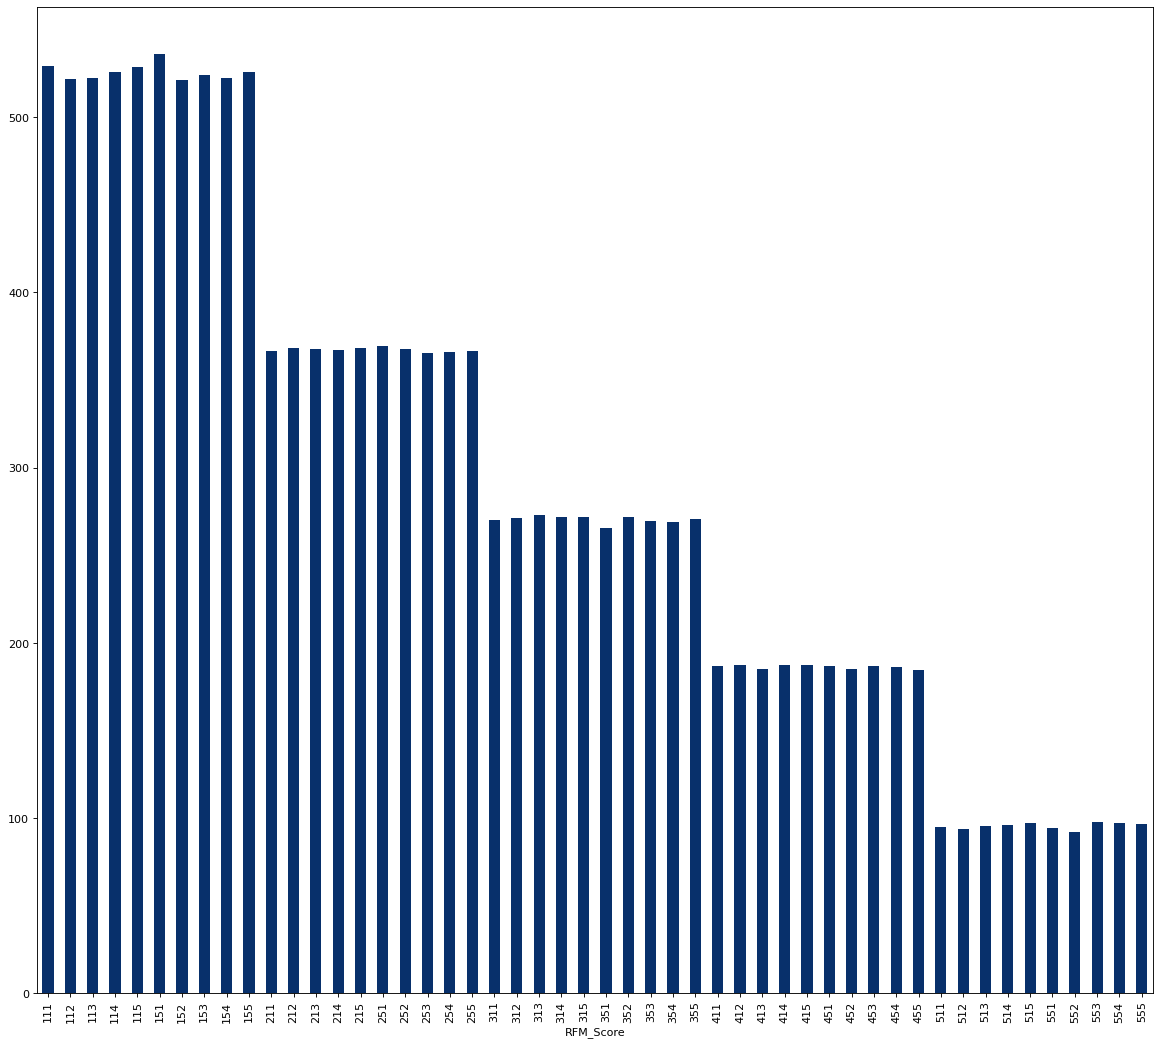

In [52]:
#Распределение сегментов по объему
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
rfm.groupby('RFM_Score').agg('Recency').mean().plot(kind='bar', colormap='Blues_r')
plt.show()

In [53]:
#Для удобства создадим сокращенный формат оценки RFM
rfm_un = rfm.groupby('RFM_Score')['RFM_Score'].nunique()
rfm['RFM_Level'] = rfm[['R','F','M']].sum(axis=1)
print(rfm['RFM_Level'].head())

CustomerID
0000366f3b9a7992bf8c76cfdf3221e2    9
0000b849f77a49e4a4ce2b2a4ca5be3f    6
0000f46a3911fa3c0805444483337064    4
0000f6ccb0745a6a4b88665a16c9f078    4
0004aac84e0df4da2b147fca70cf8255    8
Name: RFM_Level, dtype: int64


In [54]:
#Обозначим сегменты через функцию
def rfm_level(df):
    if df['RFM_Level'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Level'] >= 8) and (df['RFM_Level'] < 9)):
        return 'Champions'
    elif ((df['RFM_Level'] >= 7) and (df['RFM_Level'] < 8)):
        return 'Loyal/Commited'
    elif ((df['RFM_Level'] >= 6) and (df['RFM_Level'] < 7)):
        return 'Potential'
    elif ((df['RFM_Level'] >= 5) and (df['RFM_Level'] < 6)):
        return 'Promising'
    elif ((df['RFM_Level'] >= 4) and (df['RFM_Level'] < 5)):
        return 'Requires Attention'
    else:
        return 'Demands Activation'
rfm['Segment'] = rfm.apply(rfm_level, axis=1)
rfm.head(15)

,Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM_Level,Segment
CustomerID,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,161,1,129.90,4,1,4,414,9,Can't Loose Them
0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,18.90,4,1,1,411,6,Potential
0000f46a3911fa3c0805444483337064,586,1,69.00,1,1,2,112,4,Requires Attention
0000f6ccb0745a6a4b88665a16c9f078,370,1,25.99,2,1,1,211,4,Requires Attention
0004aac84e0df4da2b147fca70cf8255,337,1,180.00,2,1,5,215,8,Champions
0004bd2a26a76fe21f786e4fbd80607f,195,1,154.00,4,1,4,414,9,Can't Loose Them
00050ab1314c0e55a6ca13cf7181fecf,181,1,27.99,4,1,1,411,6,Potential
00053a61a98854899e70ed204dd4bafe,232,2,382.00,3,5,5,355,13,Can't Loose Them
0005e1862207bf6ccc02e4228effd9a0,592,1,135.00,1,1,4,114,6,Potential


In [55]:
#Посчитаем среднее для каждой категории по сегментам
rfm_mean = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
                                        }).round(1)
print(rfm_mean)

                   Recency Frequency Monetary       
                      mean      mean     mean  count
Segment                                             
Can't Loose Them     197.9       1.6    240.3  30141
Champions            231.2       1.0    159.3  13569
Demands Activation   529.2       1.0     23.2   3942
Loyal/Commited       280.0       1.0    132.7  16848
Potential            329.7       1.0     73.6  13228
Promising            382.7       1.0     54.4  11089
Requires Attention   444.5       1.0     38.7   7279


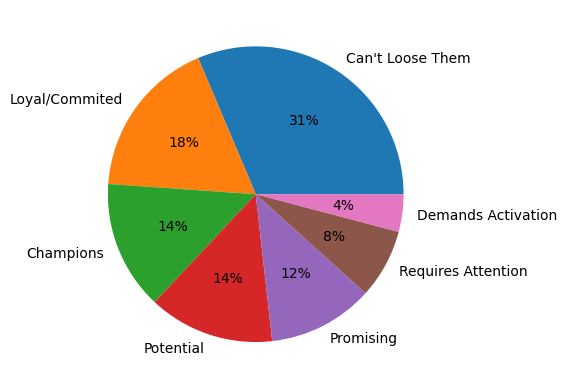

In [56]:
#Визуализирую
plt.pie(rfm.Segment.value_counts(),
        labels=rfm.Segment.value_counts().index,
        autopct='%.0f%%')
plt.show()